# Slope Analysis in Gabon Study Area

In [2]:
import xarray as xr
import os 
import glob
from matplotlib import pyplot as plt
import numpy as np
import rioxarray as rx
import geopandas as gpd
from datetime import datetime as dt
import pandas as pd
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1 import ImageGrid
from scipy import stats
from matplotlib import rc
import rasterio as rio

In [3]:
R = '/exports/csce/datastore/geos/users/s1332488/chapter1_data/'
slope = xr.open_rasterio(R+'elevation/Slope_Gabon.tif').rio.write_crs('EPSG:4326')
# SRTM slope calculated at 30 m from SRTM data in Google Earth Enginge
slope_br = xr.open_rasterio(R+'elevation/tapajos_plots_slope.tif').rio.write_crs('EPSG:4326')

In [4]:
# Get plot shapefiles -------------------------------------------
SHP_dir='/exports/csce/datastore/geos/groups/MitchardGroupData/FODEX/core_plot_shapefiles/'
shps = gpd.read_file(SHP_dir+'core_plots_10mBuffer.shp')
#shps_nobuff = gpd.read_file(SHP_dir+'core_plots.shp')
shps_bg = gpd.read_file(SHP_dir+'background_plots.shp')
lidar = gpd.read_file(R+'elevation/lidar_extent.shp')

def crop(ds,plot,all_touched=False):
    # Crop an xarray object 'ds' to plot
    # plot is a string e.g. 'PC1' or 'GC4'
    # pass all_touched = True to include pixels that partially intersect the plot
    #ds.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
    if 'B' in plot:
        shape = shps_bg[shps_bg.layer==plot].geometry
    else:
        shape = shps[shps.layer==plot].geometry
    return ds.rio.clip(shape,all_touched=all_touched)

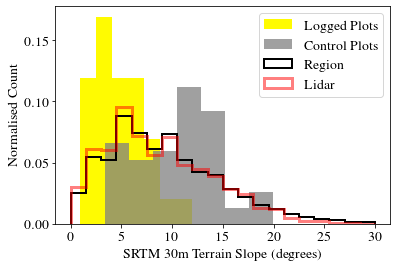

In [5]:
plt.rcParams.update({'font.size': 14})

#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

core_plots = []
bg_plots = []

for p in ['GC' + i for i in ['1','2','3','4']]:
    core_plots += list(crop(slope,p).values.flatten())
for p in ['GB' + i for i in ['1','2','3','4','5','6']]:
    bg_plots += list(crop(slope,p).values.flatten())
plt.hist(core_plots,density=True,alpha=1,label='Logged Plots',color='#fffb01',bins=7)
plt.hist(bg_plots,density=True,alpha=0.75,label='Control Plots',color='grey',bins=7)
slope.plot.hist(density=True,range=(0,30),bins=20,histtype=u'step',
                       color='black',label='Region',lw=2)
slope.rio.clip(lidar.geometry).plot.hist(density=True,range=(0,30),
                                         bins=20,histtype=u'step',label='Lidar',color='red',
                                         alpha=0.5,lw=3)
#slope_br.plot.hist(density=True,label='Tapajos',histtype=u'step',color='green',bins=15)
plt.title('')
plt.xlabel('SRTM 30m Terrain Slope (degrees)',)
plt.ylabel('Normalised Count',)
plt.legend()
plt.savefig('/home/s1332488/chapter1/figure2/hist.png',dpi=300)
plt.show()

## Analysis of slope across tropical rainforests

In [4]:
slope_90 = R+'elevation/HTF_slope90_merged.tif'
slope_90 = xr.open_rasterio(slope_90)
# FIRST BAND 1km resolution raster containing 90th percentile of SRTM slopes in each pixel
# masked to contain only tropical rainforest areas
# I.e. if a pixel contians the value 15, 
# then ten percent of the land in that 1 km cell is sloping by at least 15 degrees
# SECOND BAND - fraction of 1km cell covered by primary humid tropical forest in 2001

In [5]:
def percent_hilly(H): # H is slope value     
    hilly = slope_90.sel(band=1) >= H
    hilly_forest = (slope_90.sel(band=2) * hilly).sum()
    not_hilly_forest = (slope_90.sel(band=2) * ~hilly).sum()

    return float( 100 * hilly_forest / (hilly_forest + not_hilly_forest) )

In [6]:
ph10 = percent_hilly(10)
ph20 = percent_hilly(20)
ph30 = percent_hilly(30)
ph40 = percent_hilly(40)

In [8]:
# Percent of pixels where more than 10% of slopes are greater than 10 degrees
ph10

48.68499051570994